In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from openai import OpenAI
import os 
from timeit import default_timer as timer
import json

In [9]:
def create_prompt(prompt,model_a_response,model_b_response):
    ''' Create a prompt asking to evalute the answer of the 2 model based on the base prompt and the two model answer. 

    Parameters:
    prompt (str) : The orignal prompt
    model_a_response (str)   : Answer generated by model a
    model_b_response (str)   : Answer generated by model b

    Returns:
    str  : Prompt given to gpt-4o-mini to evaluate the two answer. 
    '''
    content_system = '''
    You are an AI judge evaluating responses from two different models to determine which one provides a better answer to a given prompt. 
    Use the following step-by-step instructions to respond to user inputs.\n

    Step 1 - The user will provide you with the prompt delimited by <prompt>, the model a response delimited by <model_a_response> and the model b response delimited by <model_b_Response>. Analyze the prompt. \n

    Step 2 - Compare the two answer and look for similarity and difference. For the difference choose which model is wrong. \n

    Step 3 - Decide which model as a more conscice, factual and pedagogial answer. Give the result in JSON format while explaining why you choose this model. If the 2 answer are similar you can answer "Tie". \n

    Here is an example. 
    Question : <prompt> What is an hexagone </prompt> \n
    Model A response:
    <model_a_response>
    "An hexagone is a plane figure with six straight sides and angles."
    </model_a_response> \n
    Model B response:
    <model_b_response>
    ""An hexagone is a plane figure with seven straight sides and angles."
    </model_b_response> \n
    Answer: {
        Answer : "A", 
        Explication : "Model b is giving a false information by explaning that an hexagone has seven sides
    }
    '''
    content_user = f'''
    User prompt:
    <prompt>
    {prompt}
    </prompt> \n
    Model A response:
    <model_a_response>
    "{model_a_response}"
    </model_a_response> \n
    Model B response:
    <model_b_response>
    "{model_b_response}"
    </model_b_response> \n
     '''
    return content_system,content_user

In [ ]:
def load_dataset(path,n):
    ''' Load the prompt, the reponse of model a and response of model b and process it.

    Parameters:
    path (str) : path of csv file containing the dataset
    n (int)   : Number of row to load in ascending order. 
    
    Returns:
    list  : List of tuples containing the processed prompt,reponse a and b. 
    '''
    df = pd.read_csv(path)
    serie = df[['prompt','response_a','response_b']].iloc[0:n]
    data = []
    for row in serie.itertuples(index = False,name = None):
        processed_text = []
        for txt in row: 
            processed_text.append(process_string(txt,2))
        data.append(processed_text)
    return data

def process_string(str,n):
    ''' Process string str by removing the n first and last character.

    Parameters:
    str (str) : String to process
    n (int)   : Number of character to trim
    
    Returns:
    str : Processed string
    '''
    return str[n:len(str)-n]



In [11]:


openai_api_key = os.environ.get('OPENAI_API_KEY')
client = OpenAI(api_key = openai_api_key)
list = []

def inference(content):
    ''' Call OpenAI API to answer to a prompt based on content

    Parameters:
    content (list) : List of 3 string used to create the final prompt.
    
    Returns:
    completion : Answer of the model 
    '''
    content_system,content_user = create_prompt(content[0],content[1],content[2])
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": content_system},
            {
                "role": "user",
                "content": content_user
            }
        ],
        response_format={"type": "json_object"}
    )
    return completion


In [32]:


def processing_answer(answer):
    ''' Process the answer of the model an create a dataframe

    Parameters:
    answer (list) : List of chat completion
    
    Returns:
    dataframe : Dataframe with 2 rows : "Prediction" and "Explication" and len(answer) row containing the model choice and the explication
    '''
    processed_answer_list = []
    for idx,ans in enumerate(answer):
        msg = ans.choices[0].message.content
        msg_json = json.loads(msg)
        processed_answer = (msg_json['Answer'],msg_json['Explication'],ans.usage.prompt_tokens,ans.usage.completion_tokens)
        processed_answer_list.append(processed_answer)
    dataframe = pd.DataFrame(processed_answer_list,columns=["Prediction","Explication","Prompt token","Completion tokens"])
    return dataframe

def multiple_inference(n):
    ''' Multiple inference


    Returns:
    dataframe : Dataframe with 2 rows : "Answer" and "Explication" and len(answer) row containing the model choice and the explication
    list : list of chat completion
    '''
    print(f"Start of data loading")
    start = timer()
    dataset = load_dataset('data/train.csv',n)
    end = timer()
    print("End of data loading after " + "{:.3f}".format(end-start) + "s")

    answer = []
    print(f"Start of Inference - Number of inference : {len(dataset)}")
    start = timer()
    for data in dataset:
        answer.append(inference(data))
    
    end = timer()
    print("End of Inference after " + "{:.3f}".format(end-start) + "s")

    return processing_answer(answer),answer


In [50]:
def evaluation(df_predictions):
    df = pd.read_csv('data/train.csv')
    print(len(df_predictions.columns)+1)
    df_ground_truth = df[['winner_model_a','winner_model_b','winner_tie']].iloc[:len(df_predictions.index)] 
    
    class_labels = ['A', 'B', 'Tie']

    df_ground_truth['true_label'] = df_ground_truth.apply(lambda row: class_labels[np.argmax(row.values)], axis=1)
    
    # Extract True Labels and Predictions
    y_true = df_ground_truth['true_label']
    y_pred = df_predictions['Prediction']
    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)

    # Plot Confusion Matrix
    plt.figure(figsize=(6,5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
    


In [52]:
df_predictions,raw = multiple_inference(1000)


Start of data loading
End of data loading after 1.580s
Start of Inference - Number of inference : 1000
End of Inference after 2086.729s


KeyError: 'Explication'

In [53]:
len(raw)

50

5
              precision    recall  f1-score  support
A              0.428571  0.857143  0.571429    14.00
B              0.533333  0.400000  0.457143    20.00
Tie            0.571429  0.250000  0.347826    16.00
accuracy       0.480000  0.480000  0.480000     0.48
macro avg      0.511111  0.502381  0.458799    50.00
weighted avg   0.516190  0.480000  0.454161    50.00


<Figure size 600x500 with 0 Axes>

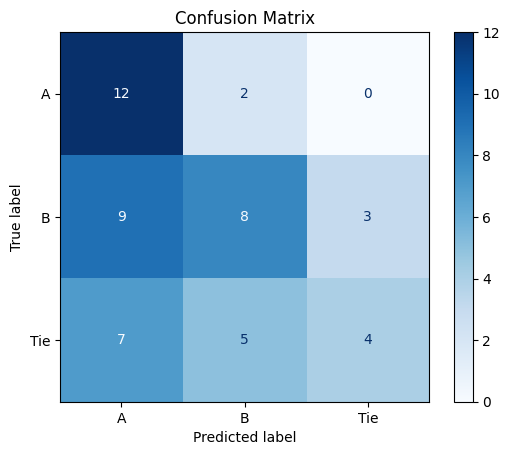

In [51]:
evaluation(df_predictions = df_predictions)

In [ ]:
def create_batch_file(data: pd.DataFrame, path: str, model: str, max_token: int):
    """
    Creates a .jsonl batch file for OpenAI's chat completion API.

    Parameters:
        data (pd.DataFrame): A DataFrame with 'system_content' and 'user_content' columns.
        path (str): The output file path (should end with .jsonl).
        model (str): The OpenAI model to use (e.g., 'gpt-3.5-turbo-0125').
        max_token (int): The max tokens per response.
    """
    with open(path, "w", encoding="utf-8") as f:
        for idx, row in data.iterrows():
            sys,user = create_prompt(data[0],data[1],data[2])
            batch_entry = {
                "custom_id": f"request-{idx+1}",
                "method": "POST",
                "url": "/v1/chat/completions",
                "body": {
                    "model": model,
                    "messages": [
                        {"role": "system", "content": sys},
                        {"role": "user", "content": user}
                    ],
                    "max_tokens": max_token
                }
            }
            f.write(json.dumps(batch_entry) + "\n")

# Example usage
dataset = load_dataset('data/train.csv',10)
create_batch_file(dataset, "batch/batch_requests.jsonl", "gpt-4o-mini", 1000)


50

In [ ]:
{"custom_id": "request-1", "method": "POST", "url": "/v1/chat/completions", "body": {"model": "gpt-3.5-turbo-0125", "messages": [{"role": "system", "content": "You are a helpful assistant."},{"role": "user", "content": "Hello world!"}],"max_tokens": 1000}}
{"custom_id": "request-2", "method": "POST", "url": "/v1/chat/completions", "body": {"model": "gpt-3.5-turbo-0125", "messages": [{"role": "system", "content": "You are an unhelpful assistant."},{"role": "user", "content": "Hello world!"}],"max_tokens": 1000}}